<a href="https://colab.research.google.com/github/AmbiTyga/Bio-VI-BERT/blob/main/Pre_trained_Image_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title EarlyStopping
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [ ]:
!git clone https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models
!pip install -r requirements.txt -q
!python setup.py install -q
%cd ..

import os
os.kill(os.getpid(), 9)
# Restart Runtime

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4594 (delta 5), reused 19 (delta 4), pack-reused 4572
Receiving objects: 100% (4594/4594), 15.78 MiB | 11.52 MiB/s, done.
Resolving deltas: 100% (3303/3303), done.
/content/pytorch-image-models
running install
running bdist_egg
running egg_info
creating timm.egg-info
writing timm.egg-info/PKG-INFO
writing dependency_links to timm.egg-info/dependency_links.txt
writing requirements to timm.egg-info/requires.txt
writing top-level names to timm.egg-info/top_level.txt
writing manifest file 'timm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'timm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/timm
copying timm/version.py -> build/lib/timm
copying timm

In [2]:
!wget https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
!7z x /content/Dataset.7z

--2021-03-02 16:22:56--  https://raw.githubusercontent.com/AmbiTyga/Bio-VI-BERT/main/Dataset.7z
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17231696 (16M) [application/octet-stream]
Saving to: ‘Dataset.7z’

Dataset.7z          100%[===================>]  16.43M  55.5MB/s    in 0.3s    

2021-03-02 16:22:57 (55.5 MB/s) - ‘Dataset.7z’ saved [17231696/17231696]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 17231696 bytes (17 MiB)

Extracting archive: /content/Dataset.7z
--
Path = /content/Dat

In [3]:
import timm
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import train_test_split

from PIL import Image
from torchvision import transforms

## Cleaning and getting a final data

In [4]:
## Getting images(file path) from the directories 

imgs = []
for path, subdirs, files in os.walk('./Dataset'):
    for name in files:
        imgs.append(os.path.join(path, name))
imgs = [x for x in imgs if '.jpg' in x]

In [5]:
data = pd.read_csv("/content/Dataset/all_meta_data.csv")
data.head()

,phylum,class,genus,species,form,sample,image_name,image_url,img_path
0,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_worm4_HB.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_worm4_HB.jpg
1,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_HBa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_HBa.jpg
2,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_wtmt.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_wtmt.jpg
3,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_SC_egg.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_SC_egg.jpg
4,Nematoda,Chromadorea,Enterobius,Enterobius vermicularis,egg,intestinal tissue,Evermicularis_egg_UVa.jpg,https://www.cdc.gov//dpdx/enterobiasis/images/...,./Dataset/Enterobius/Evermicularis_egg_UVa.jpg


In [6]:
# Dropping unnecessary datapoints
def check_file(x):
  if x not in imgs:
    return 'N\A'
  else:
    return x


data['img_path'] = data['img_path'].apply(check_file)
data.drop(index = data[data['img_path']=='N\A'].index,inplace = True)
data.to_csv('/content/Parasitesv1.csv',index=False)

In [18]:
data = pd.read_csv('/content/Parasitesv1.csv')

In [19]:
data = [x for _,x in data.groupby('species') if len(x)>15]

data = pd.concat(data,ignore_index=True)

In [20]:
train, val = train_test_split(
    data, test_size=0.13, random_state=2021,stratify = data['species'])

In [21]:
train.to_csv('/content/train.csv',index = False)

val.to_csv('/content/val.csv',index = False)

# Dataset Function

In [10]:
class SpeciesDataset(Dataset):
  def __init__(self,csv_file,transform):
    super().__init__()
    csv = pd.read_csv(csv_file)[['species','img_path']]
    labels = csv['species'].values

    self.images = csv['img_path'].values
    self.transform = transform

    self.LE = LabelEncoder()
    self.labels = self.LE.fit_transform(labels)    

  def __len__(self):
    # return size of dataset
    return len(self.images)

  def __getitem__(self, index):
    img = Image.open(self.images[index])
    img = self.transform(img)

    label = self.labels[index]

    return img, torch.LongTensor([label])

In [11]:

train_transformer = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        # transforms.
        # transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomRotation(90),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transformer = transforms.Compose([
        transforms.Resize((224,224)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [43]:
len(val)

48

In [54]:
train_dataset = SpeciesDataset('/content/train.csv',transform=train_transformer)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=2)

val_dataset = SpeciesDataset('/content/val.csv',transform=val_transformer)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=48)

# VIT Base Imagenet 21k

In [80]:
class ViT(nn.Module):
  def __init__(self,num_classes_classifier=15):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_patch16_224_in21k(pretrained=True,num_classes = 512)
    self.drop = nn.Dropout(0.4)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = self.drop(repr)
    output = self.classifier(repr)

    return output  

In [81]:
model = ViT()

Removing representation layer for fine-tuning.


In [90]:
model.load_state_dict(torch.load('vit_resnet.bin'))

<All keys matched successfully>

In [91]:
torch.seed()

2718668111938001523

In [92]:
device = torch.device('cuda')
# optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = 0.960

model.cuda()

# train_losses = []
# train_accs = []
# val_losses = []
# val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit-base.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 0.111, Train Acc: 97.45%, Val. Loss: 1.135, Val. Acc: 62.50% 
	 Patience -> 9
Epoch: 02, Train Loss: 0.123, Train Acc: 96.50%, Val. Loss: 1.236, Val. Acc: 62.50% 
	 Patience -> 8
Epoch: 03, Train Loss: 0.187, Train Acc: 94.59%, Val. Loss: 1.480, Val. Acc: 64.58% 
	 Patience -> 7
Epoch: 04, Train Loss: 0.140, Train Acc: 97.77%, Val. Loss: 1.644, Val. Acc: 60.42% 
	 Patience -> 6
Epoch: 05, Train Loss: 0.341, Train Acc: 88.85%, Val. Loss: 1.737, Val. Acc: 58.33% 
	 Patience -> 5
Epoch: 06, Train Loss: 0.263, Train Acc: 92.99%, Val. Loss: 1.559, Val. Acc: 60.42% 
	 Patience -> 4
Epoch: 07, Train Loss: 0.334, Train Acc: 89.49%, Val. Loss: 1.996, Val. Acc: 58.33% 
	 Patience -> 3
Epoch: 08, Train Loss: 0.162, Train Acc: 95.86%, Val. Loss: 1.852, Val. Acc: 50.00% 
	 Patience -> 2
Epoch: 09, Train Loss: 0.118, Train Acc: 95.54%, Val. Loss: 1.875, Val. Acc: 60.42% 
	 Patience -> 1
Epoch: 10, Train Loss: 0.464, Train Acc: 85.35%, Val. Loss: 1.661, Val. Acc: 62.50% 
	Patie

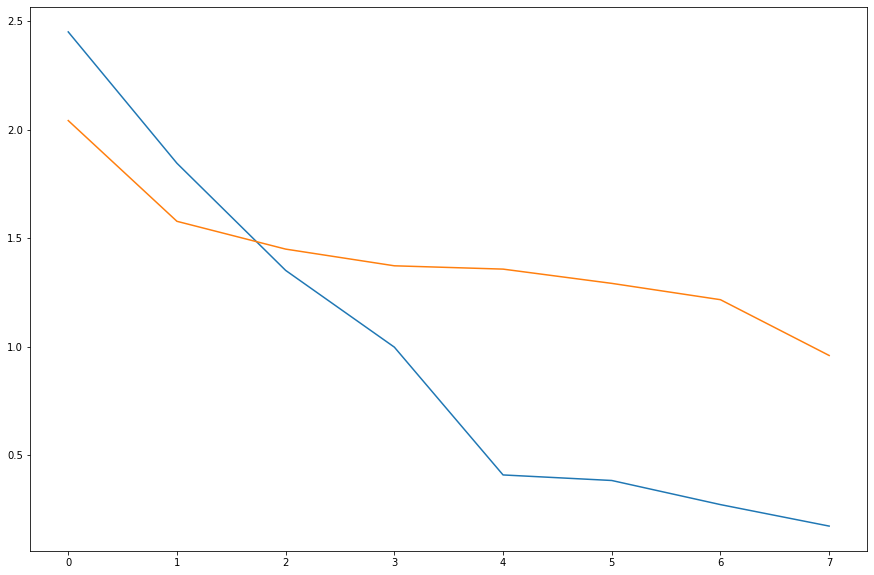

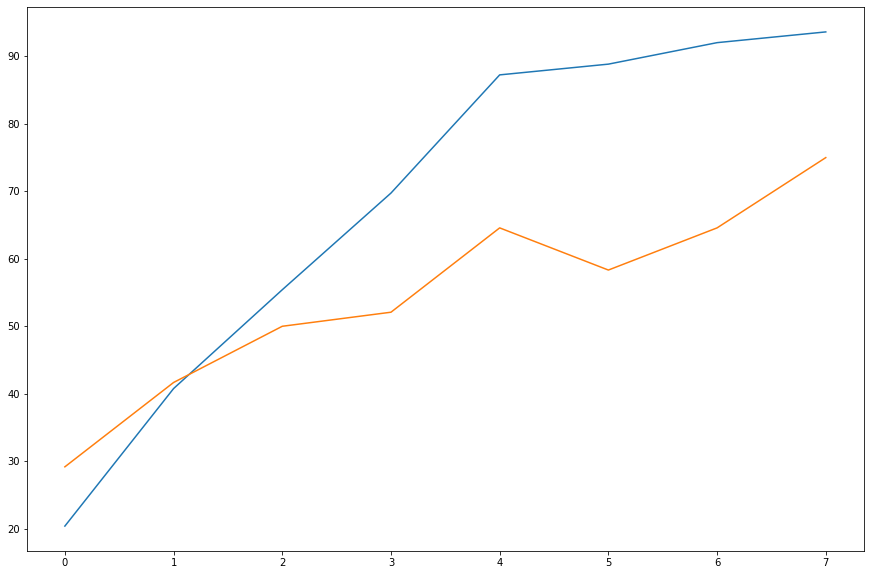

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.show()

In [94]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load('vit-base.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=val_dataset.LE.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       1.00      1.00      1.00         2
     Ascaris lumbricoides       0.57      1.00      0.73         4
      Cryptosporidium sp.       0.00      0.00      0.00         2
  Cyclospora cayetanensis       0.75      0.75      0.75         4
  Dibothriocephalus latus       1.00      0.67      0.80         3
   Entamoeba histolytica]       1.00      1.00      1.00         3
  Enterobius vermicularis       1.00      1.00      1.00         2
       Giardia duodenalis       1.00      0.75      0.86         4
    Plasmodium falciparum       0.62      1.00      0.77         5
      Plasmodium malariae       0.60      0.75      0.67         4
         Plasmodium ovale       1.00      0.25      0.40         4
         Plasmodium vivax       0.75      0.60      0.67         5
          Sarcocystis sp.       1.00      1.00      1.00         2
Strongyloides stercoralis       0.67      1.00      0.80     

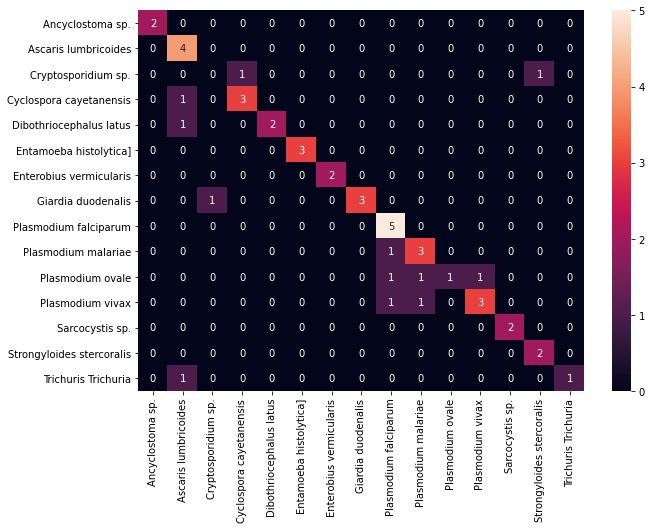

In [95]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = val_dataset.LE.classes_,
                  columns = val_dataset.LE.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# VIT Resnet50 Imagenet 21k

In [102]:
class ViResNet50(nn.Module):
  def __init__(self,num_classes_classifier=15):
    super().__init__()
    self.img_transformer = timm.models.vision_transformer.vit_base_resnet50_224_in21k(pretrained=True,num_classes = 512)
    self.drop = nn.Dropout(0.4)
    self.classifier = nn.Linear(512,num_classes_classifier)

  def forward(self,img):
    repr = self.img_transformer(img)
    repr = self.drop(repr)
    output = self.classifier(repr)

    return output  

In [103]:
model = ViResNet50()

Removing representation layer for fine-tuning.


In [109]:
model.load_state_dict(torch.load('vit-resnet.bin'))

<All keys matched successfully>

In [100]:
torch.seed()

14185017976319700136

In [110]:
device = torch.device('cuda')
# optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr = 1e-4)
loss_fn = nn.CrossEntropyLoss().to(device)
es = EarlyStopping(patience = 10)
es.best = 1.273

model.cuda()

# train_losses = []
# train_accs = []
# val_losses = []
# val_accs = []
for epoch in range(100):
  train_epoch_loss = 0
  train_epoch_acc = 0
  model.train()
  steps = 0
  for idx, batch in enumerate(train_loader):
    image, target = batch
    image = image.to(device)
    target = target.flatten().to(device)

    optim.zero_grad()

    prediction = model(image)
    # print(prediction,target)
    loss = loss_fn(prediction, target)

    num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
    acc = 100.0 * (num_corrects/target.size(0))
    loss.backward()
    optim.step()
    steps += 1
    
    # if steps % 6 == 0:
    #     print (f'\t Train - Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
    
    train_epoch_loss += loss.item()
    train_epoch_acc += acc.item()

  val_epoch_loss = 0
  val_epoch_acc = 0
  model.eval()
  val_steps = 0
  with torch.no_grad():
    for idx, batch in enumerate(val_loader):
      image, target = batch
      image = image.to(device)
      target = target.flatten().to(device)

      prediction = model(image)
      loss = loss_fn(prediction, target)
      
      num_corrects = (prediction.argmax(dim=1).view(target.size()).data == target.data).sum()
      acc = 100.0 * (num_corrects/target.size(0))

      val_epoch_loss += loss.item()
      val_epoch_acc += acc.item()
      val_steps +=1

  
  val_epoch_loss /=val_steps
  val_epoch_acc /=val_steps

  # val_losses.append(val_epoch_loss)
  # val_accs.append(val_epoch_acc)
  
  print(f"Epoch: {epoch+1:02}, Train Loss: {train_epoch_loss/steps:.3f}, Train Acc: {train_epoch_acc/steps:.2f}%, Val. Loss: {val_epoch_loss:.3f}, Val. Acc: {val_epoch_acc:.2f}% \n{90*'='}")
  
  if val_epoch_loss < es.best:
    best_loss = val_epoch_loss
    print(f'\r\t{es.best:.3f} --> {best_loss:.3f}  Updating')
    torch.save(model.state_dict(),'vit-resnet.bin')

    train_losses.append(train_epoch_loss/steps)
    train_accs.append(train_epoch_acc/steps)

    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
  if es.step(torch.tensor(val_epoch_loss)):
    print(f'\r\tPatience complete! Best Loss is {es.best:.3f}')
    break
  if val_epoch_loss > best_loss:
    print(f'\r\t Patience -> {es.patience - es.num_bad_epochs}')

Epoch: 01, Train Loss: 0.458, Train Acc: 85.99%, Val. Loss: 1.435, Val. Acc: 64.58% 
	 Patience -> 9
Epoch: 02, Train Loss: 0.521, Train Acc: 83.44%, Val. Loss: 1.725, Val. Acc: 62.50% 
	 Patience -> 8
Epoch: 03, Train Loss: 0.139, Train Acc: 95.54%, Val. Loss: 1.365, Val. Acc: 66.67% 
	 Patience -> 7
Epoch: 04, Train Loss: 0.152, Train Acc: 95.22%, Val. Loss: 1.795, Val. Acc: 62.50% 
	 Patience -> 6
Epoch: 05, Train Loss: 0.432, Train Acc: 89.17%, Val. Loss: 2.065, Val. Acc: 58.33% 
	 Patience -> 5
Epoch: 06, Train Loss: 0.431, Train Acc: 87.58%, Val. Loss: 1.969, Val. Acc: 64.58% 
	 Patience -> 4
Epoch: 07, Train Loss: 0.374, Train Acc: 90.13%, Val. Loss: 1.198, Val. Acc: 66.67% 
	1.273 --> 1.198  Updating
Epoch: 08, Train Loss: 0.208, Train Acc: 93.63%, Val. Loss: 1.425, Val. Acc: 66.67% 
	 Patience -> 9
Epoch: 09, Train Loss: 0.163, Train Acc: 93.95%, Val. Loss: 2.020, Val. Acc: 62.50% 
	 Patience -> 8
Epoch: 10, Train Loss: 0.150, Train Acc: 95.22%, Val. Loss: 1.622, Val. Acc: 62.

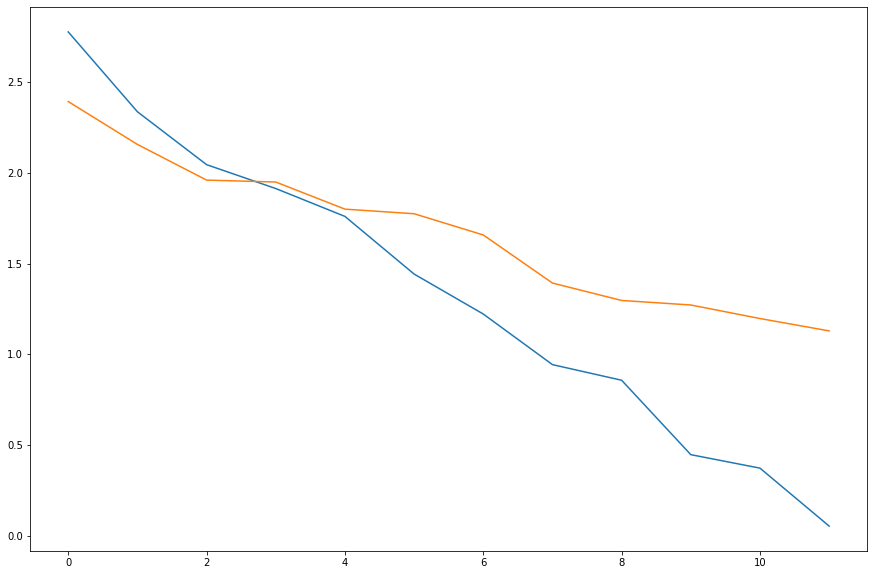

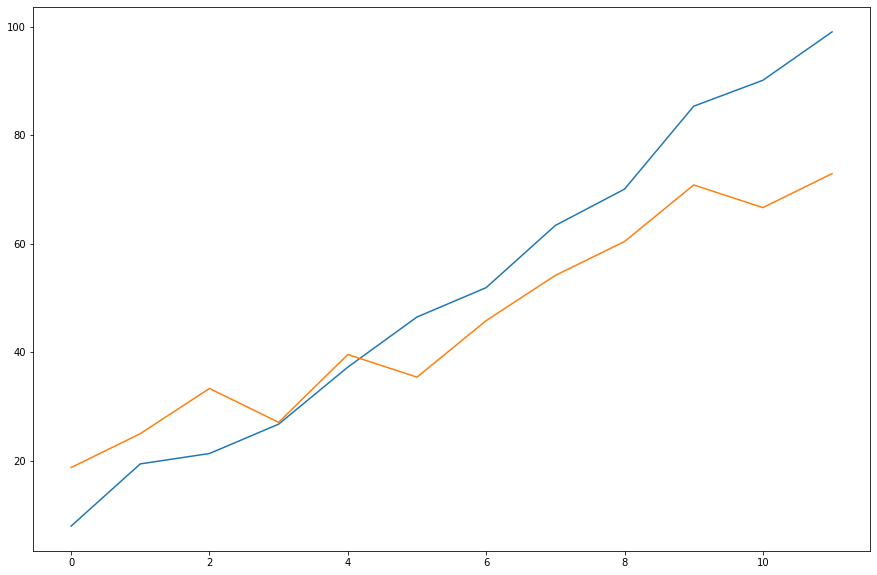

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(train_accs,label='Training Accuracy')
plt.plot(val_accs,label='Validation Accuracy')
plt.show()

In [112]:
from sklearn.metrics import classification_report, confusion_matrix

model.load_state_dict(torch.load('vit-resnet.bin'))
model.cuda()
with torch.no_grad():
  image,target = next(iter(val_loader))
  image = image.to(device)
  target = target.flatten().to(device)

  prediction = model(image)

prediction = prediction.argmax(dim=1).view(target.size()).cpu().numpy()
target = target.cpu().numpy()

print(classification_report(target,prediction,target_names=val_dataset.LE.classes_))

                           precision    recall  f1-score   support

         Ancyclostoma sp.       0.50      0.50      0.50         2
     Ascaris lumbricoides       0.67      1.00      0.80         4
      Cryptosporidium sp.       0.33      0.50      0.40         2
  Cyclospora cayetanensis       0.80      1.00      0.89         4
  Dibothriocephalus latus       1.00      1.00      1.00         3
   Entamoeba histolytica]       1.00      1.00      1.00         3
  Enterobius vermicularis       1.00      0.50      0.67         2
       Giardia duodenalis       1.00      0.75      0.86         4
    Plasmodium falciparum       0.56      1.00      0.71         5
      Plasmodium malariae       1.00      0.25      0.40         4
         Plasmodium ovale       0.50      0.25      0.33         4
         Plasmodium vivax       0.67      0.80      0.73         5
          Sarcocystis sp.       1.00      0.50      0.67         2
Strongyloides stercoralis       1.00      0.50      0.67     

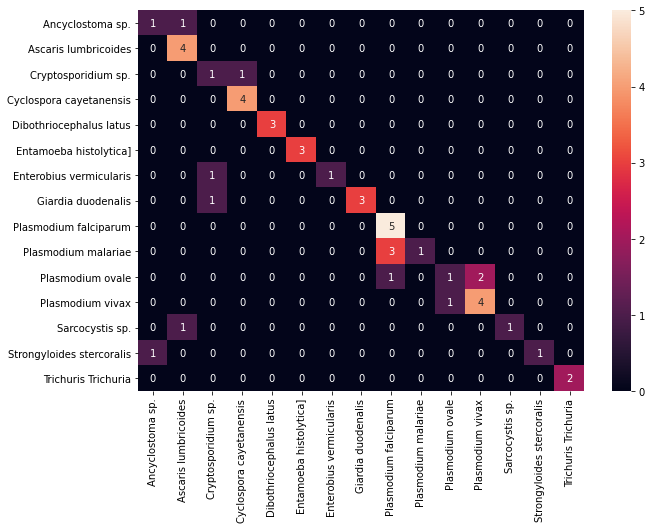

In [113]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
confusion = confusion_matrix(target,prediction)
df_cm = pd.DataFrame(confusion, index = val_dataset.LE.classes_,
                  columns = val_dataset.LE.classes_)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()